# Global Fishing Effort for Longliners

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
# from scipy import stats

In [4]:
import bq  
client = bq.Client.Get()

In [5]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer


In [18]:
q = '''
SELECT
  INTEGER(latitude*2) lat_bin,
  INTEGER(longitude*2) lon_bin,
  SUM(hours_since_last_timestamp) fishing_hours,
  avg(distance_to_shore) distance_to_shore
FROM (
  SELECT
    latitude,
    longitude,
    CASE WHEN hours_since_last_timestamp>12 THEN 12
    WHEN hours_since_last_timestamp IS NULL THEN 0 
    ELSE hours_since_last_timestamp END hours_since_last_timestamp,
    distance_to_shore
  FROM
    [scratch_global_fishing_raster.Jan_July_2015_FishingVessels_Time]
  WHERE
    mmsi IN (
    SELECT
      mmsi
    FROM
      [scratch_global_fishing_raster.classification_20160324]
    WHERE
      label = 'Longliner' and score >.5)
    AND sog > 2.5
    AND sog < 5.5
    and distance_to_shore>5
    )
GROUP BY
  lat_bin,
  lon_bin
'''

fishing_grid = Query(q)

Waiting on bqjob_r507c2896ccc31a86_00000153ede45989_4 ... (0s) Current status: DONE   
Query time: 2.01449584961 seconds.


In [19]:
cellsize = .5
one_over_cellsize = 2
max_lat = 90
min_lat = -90
min_lon = -180
max_lon = 180

num_lats = (max_lat-min_lat)*one_over_cellsize
num_lons = (max_lon-min_lon)*one_over_cellsize

grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = float(row[2])

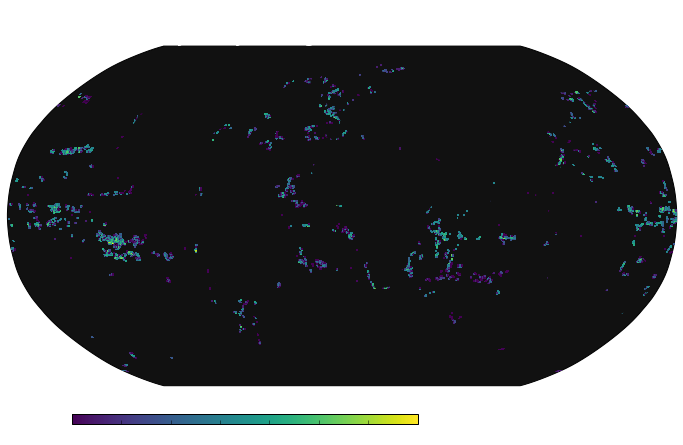

In [20]:
plt.rcParams["figure.figsize"] = [12,7]

cutoff = 0 # 4 degress away from the pole
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
one_over_cellsize = 2

fishing_days_truncated = grid[one_over_cellsize*cutoff:(180*one_over_cellsize)-cutoff*one_over_cellsize][:]

numlats = int((firstlat-lastlat)*one_over_cellsize+.5)
numlons = int((lastlon-firstlon)*one_over_cellsize+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)

m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents('#111111',lake_color='#111111')#, lake_color, ax, zorder, alpha)

x = np.linspace(-180, 180, 360*one_over_cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

maximum = grid.max()
minimum = 1

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, fishing_days_truncated, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

t = "Fishing Hours for LongLiners, January 2015 to June 2015\nOnly Likely Fishing Vessesl - 4,731 Vessels "
plt.title(t, color = "#ffffff", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

the_labels = []
for l in lvls:
    if l>=1:
        l = int(l)
    the_labels.append(l)

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#ffffff")
cb.set_label('Fishing Hours by Two Degree Grid',labelpad=-40, y=0.45, color = "#ffffff")

ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='#ffffff', fontsize=6)

plt.savefig("fishing_hours_longliner_2015Jan-Jun.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

In [21]:
q = '''
SELECT
  INTEGER(latitude*2) lat_bin,
  INTEGER(longitude*2) lon_bin,
  SUM(hours_since_last_timestamp) fishing_hours,
  avg(distance_from_shore) distance_from_shore
FROM (
  SELECT
    lat latitude,
    lon longitude,
    CASE WHEN hours_since_last_timestamp>12 THEN 12
    WHEN hours_since_last_timestamp IS NULL THEN 0 
    ELSE hours_since_last_timestamp END hours_since_last_timestamp,
    distance_from_shore
  FROM
    [scratch_global_fishing_raster.Jan_July_2015_AllVessels_Time]
  WHERE
    mmsi IN (
    SELECT
      mmsi
    FROM
      [scratch_global_fishing_raster.classification_20160324]
    WHERE
      label = 'Longliner' and score >.5)
    AND sog > 2.5
    AND sog < 5.5
    and distance_from_shore>5
    )
GROUP BY
  lat_bin,
  lon_bin
'''

fishing_grid_allvessels = Query(q)

Waiting on bqjob_rf0c1278e6e3390d_00000153ede5be82_5 ... (9s) Current status: DONE   
Query time: 15.4693570137 seconds.


In [22]:
cellsize = .5
one_over_cellsize = 2
max_lat = 90
min_lat = -90
min_lon = -180
max_lon = 180

num_lats = (max_lat-min_lat)*one_over_cellsize
num_lons = (max_lon-min_lon)*one_over_cellsize

grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid_allvessels:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = float(row[2])

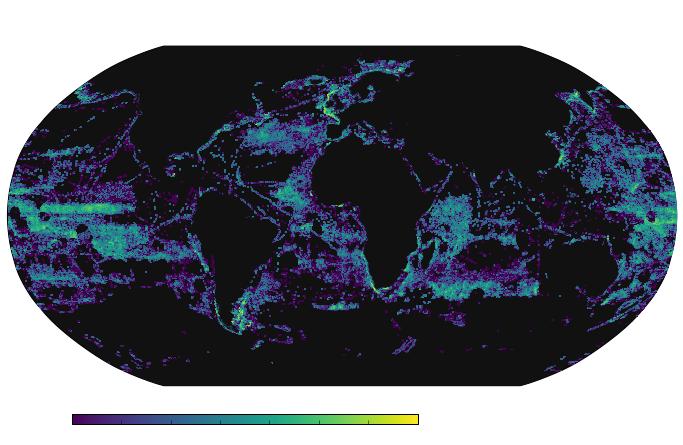

In [23]:
plt.rcParams["figure.figsize"] = [12,7]

cutoff = 0 # 4 degress away from the pole
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize
one_over_cellsize = 2

fishing_days_truncated = grid[one_over_cellsize*cutoff:(180*one_over_cellsize)-cutoff*one_over_cellsize][:]

numlats = int((firstlat-lastlat)*one_over_cellsize+.5)
numlons = int((lastlon-firstlon)*one_over_cellsize+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)

m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents('#111111',lake_color='#111111')#, lake_color, ax, zorder, alpha)

x = np.linspace(-180, 180, 360*one_over_cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

maximum = grid.max()
minimum = 1

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, fishing_days_truncated, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

t = "Fishing Hours for LongLiners, January 2015 to June 2015\nAll Classified Vessels - 13,945 Vessels"
plt.title(t, color = "#ffffff", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

the_labels = []
for l in lvls:
    if l>=1:
        l = int(l)
    the_labels.append(l)

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#ffffff")
cb.set_label('Fishing Hours by Two Degree Grid',labelpad=-40, y=0.45, color = "#ffffff")

ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='#ffffff', fontsize=6)

plt.savefig("fishing_hours_longliners_2015Jan-Jun_allvessels.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()

In [24]:
# how many vessels?
q = '''
  SELECT
    count(distinct mmsi)
  FROM
    [scratch_global_fishing_raster.Jan_July_2015_FishingVessels_Time]
  WHERE
    mmsi IN (
    SELECT
      mmsi
    FROM
      [scratch_global_fishing_raster.classification_20160324]
    WHERE
      label = 'Longliner' and score >.5)
    AND sog > 2.5
    AND sog < 5.5
    and distance_to_shore>5    
'''

likely_fishing = Query(q)

Waiting on bqjob_r26764060d6b06ee3_00000153ee09fc25_6 ... (1s) Current status: DONE   
Query time: 4.41846895218 seconds.


In [25]:
# how many vessels?
q = '''
  SELECT
    count(distinct mmsi)
  FROM
    [scratch_global_fishing_raster.Jan_July_2015_AllVessels_Time]
  WHERE
    mmsi IN (
    SELECT
      mmsi
    FROM
      [scratch_global_fishing_raster.classification_20160324]
    WHERE
      label = 'Longliner' and score >.5)
    AND sog > 2.5
    AND sog < 5.5
    and distance_from_shore>5    
'''

all_vessels = Query(q)

Waiting on bqjob_r7f7941fabec080d4_00000153ee0a1e3f_7 ... (2s) Current status: DONE   
Query time: 4.5294880867 seconds.


In [27]:
number_of_classified = Query('select count(*) from [scratch_global_fishing_raster.classification_20160324]')

Waiting on bqjob_r53164985ec87b1f1_00000153ee0a688c_8 ... (0s) Current status: DONE   
Query time: 2.31124997139 seconds.


In [30]:
print "Classified Longliners:", all_vessels[0][0]
print "Classified Longliners that are Likely Fishing Vessels:", likely_fishing[0][0]
print "All Classified Vessels of All Types:", number_of_classified[0][0]

Classified Longliners: 2543
Classified Longliners that are Likely Fishing Vessels: 934
All Classified Vessels of All Types: 180028
